In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from utils import *
import seaborn as sns
import matplotlib.patches as mpatches

import warnings
from pandas.errors import PerformanceWarning
warnings.simplefilter(action="ignore", category=PerformanceWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [17]:
names = {'vertex_ai/gemini-2.0-flash': 'Gemini 2.0 Flash', 
         'azure/gpt-4o': 'GPT-4o',
         'azure/gpt-4o-mini': 'GPT-4o Mini',
         'ollama_chat/llama3.1:8b-instruct-fp16': 'Llama 3.1 8B Instruct',
         'ollama_chat/mistral:7b-instruct': 'Mistral-v0.3 7B Instruct',
         }

names = {model_name_clean(k): v for k, v in names.items()}
names.update({'all': 'All'})

In [18]:
def wide_to_long(df):
    """
    Convert a wide DataFrame to a long format for manipulation scores.
    instead of having columns for each manipulation, we have a single column for manipulation and a single column for value.
    """
    long_rows = []
    for col in df.columns:
        if col == 'sub_task_id':
            continue
        try:
            metric, _, manipulation = col.split('--')
        except ValueError:
            continue  # skip malformed columns
    
        for sub_task_id, value in zip(df['sub_task_id'], df[col]):
            long_rows.append({
                'sub_task_id': sub_task_id,
                'metric': metric,
                'manipulation': manipulation,
                'value': value,
                'category': group_manipulations[manipulation]
            })
            
    return pd.DataFrame(long_rows)

In [19]:
group_manipulations = {
    'none': 'none',
    'money': 'positive-extrinsic',
    'competition': 'positive-extrinsic',
    'punish': 'negative-extrinsic',
    'demotivate-meaningless': 'demotivation',
    'money-loss': 'negative-extrinsic',
    'legacy': 'positive-intrinsic',
    'purpose': 'positive-intrinsic',
    'emotional-encourage': 'positive-intrinsic',
    'emotional-guilt': 'negative-extrinsic',
    'demotivate-futility': 'demotivation',    
}

manipulations = list(group_manipulations.keys())

In [20]:
metrics = {
    'motivation_score': 'Pre-self-report',
    'post_motivation_score': 'Post-self-report',
    'motivation_score_questionnaire': 'Task Performance',
    'execute_token_count': '#Tokens',
    'effort_and_engagement': 'Task Performance\n(Effort)',
    'value': 'Value',
    'interest': 'Interest',
    'challenge': 'Challenge',
    'mastery': 'Mastery',
    'fear': 'Fear',
           }

mapping = {
    'emotional-encourage': 'Encourage',
    'emotional-guilt': 'Guilt',
    'money-loss': 'Money Loss',
    'demotivate-meaningless': 'Meaningless',
    'demotivate-futility': 'Futility',
}

In [21]:
os.makedirs('plots', exist_ok=True)
os.makedirs('plots/png', exist_ok=True)
os.makedirs('plots/pdf', exist_ok=True)

In [22]:
results_dir = 'results/merged'
models = list(names.keys())

In [23]:
for model in models:
    model = model_name_clean(model)
    print(f'Analyzing manipulations for model: {model}')
    df = pd.read_csv(os.path.join(results_dir, f'{model}.csv'))
    
    numeric_cols = [col for col in df.columns 
                    if 'answer' not in col 
                    and col not in ['sub_task_id', 'task_id', 'category', 'task', 'sub_task', 'response',
           'prompt', 'success', 'error', 'error-2', 'motivation_category']]
    if model != 'all':
        numeric_cols = [col for col in numeric_cols if 'execute' not in col]
    df = df.dropna(subset=numeric_cols)
    df = agg_remove_nans(df, numeric_cols)
    
    # add a column of a joined score of questionnaire (without creativity)
    criteria = ["Task Performance Quality", "Task Completion", "Effort and Engagement", "Consistency",
                        "Creativity and Innovation", "Attention to Detail", "Relevance and Appropriateness"]
    keys = [c.replace(' ', '_').lower() for c in criteria]
    for manipulation in manipulations:
        df[f'motivation_score_questionnaire--{model}--{manipulation}'] = df[[f'{k}--{model}--{manipulation}' for k in keys]].mean(axis=1)
        
    # restructure the DataFrame to long format and take only relevant metrics
    df_long = wide_to_long(df) 
    df_long = df_long[df_long['metric'].isin(metrics.keys())].copy()
    # df_long['category'] = df_long['manipulation'].apply(group_manipulations.get)
    df_long['category'] = df_long['manipulation']  # either use the grouped (comment this line) or the original manipulations (uncomment this line)
    df_long.drop(columns=['manipulation'], inplace=True)  # drop the manipulation column as we have category now
    
    # aggregate the DataFrame by sub_task_id, manipulation, and metric
    df_agg = df_long.groupby(['sub_task_id', 'category', 'metric']).agg({'value': 'mean'}).reset_index().rename(columns={'value': 'score'})
    
    # run pairwise t-tests for each manipulation against 'none'
    from scipy.stats import ttest_rel
    all_metrics = df_agg['metric'].unique()
    all_categories = df_agg['category'].unique()
    baseline_category = 'none'
    comparison_categories = [cat for cat in all_categories if cat != baseline_category]
    
    results = []
    for metric in all_metrics:
        df_metric = df_agg[df_agg['metric'] == metric]
        results.append({
            'metric': metric,
            'category': baseline_category,
            't_stat': np.nan,
            'p_value_raw': np.nan,
            'raw_score': df_metric[df_metric['category'] == baseline_category]['score'].mean(),
        })
        for category in comparison_categories:
            pivot_df = df_metric[df_metric['category'].isin([baseline_category, category])]
            paired_df = pivot_df.pivot(index='sub_task_id', columns='category', values='score')
            t_stat, p_val = ttest_rel(paired_df[category], paired_df[baseline_category])
            results.append({
                'metric': metric,
                'category': category,
                't_stat': t_stat,
                'p_value_raw': p_val,
                'raw_score': paired_df[category].mean(),
            })
    
    results_df = pd.DataFrame(results)
    
    # adjust p-values using Benjamini-Hochberg procedure (FDR)
    from statsmodels.stats.multitest import multipletests
    
    raw_pvals = results_df.loc[~results_df['p_value_raw'].isna(), 'p_value_raw'].values
    _, corrected_pvals, _, _ = multipletests(raw_pvals, method='fdr_bh')
    
    results_df.loc[~results_df['p_value_raw'].isna(), 'p_value_corrected'] = corrected_pvals
    results_df['significant'] = results_df['p_value_corrected'] < 0.05
    
    results_df = results_df.sort_values(by=['metric', 'category'])
    results_df['metric_name'] = results_df['metric'].apply(lambda x: metrics[x])
    results_df.to_csv(f'tables/manipulation_analysis_results_{model}.csv', index=False)
    df_long['metric_name'] = df_long['metric'].apply(lambda x: metrics[x])
    df_long.loc[df_long['metric_name'] == 'Task Performance', 'value'] *= (100 / 7)
    df_long.loc[df_long['metric_name'] == 'Task Performance\n(Effort)', 'value'] *= (100 / 7)
    df_long.to_csv(f'tables/manipulation_analysis_{model}.csv')

Analyzing manipulations for model: vertex_ai_gemini-2.0-flash
Analyzing manipulations for model: azure_gpt-4o
Analyzing manipulations for model: azure_gpt-4o-mini
Analyzing manipulations for model: ollama_chat_llama3.1_8b-instruct-fp16
Analyzing manipulations for model: ollama_chat_mistral_7b-instruct
Analyzing manipulations for model: all


Plot A:
Self reports (pre and post) relative to 'none' condition 

In [24]:
manip_order = ['none', 'money', 'competition',
               'legacy', 'purpose', 'emotional-encourage', 
               'emotional-guilt', 'punish', 'money-loss',
               'demotivate-meaningless', 'demotivate-futility']

new_manip_order = [mapping.get(m, m.capitalize()) for m in manip_order]

In [25]:
df_long = pd.read_csv(f'tables/manipulation_analysis_all.csv')
plot_a1_df = df_long[df_long['metric_name'] == 'Pre-self-report'].rename(columns={'category': 'manipulation'})
# subtract 'none' score from all other manipulations for each task
none_scores = plot_a1_df[plot_a1_df['manipulation'] == 'none'][['sub_task_id', 'value']]
for manip in manip_order:
    for idx in plot_a1_df[plot_a1_df['manipulation'] == manip]['sub_task_id'].unique():
        none_score = none_scores.loc[none_scores['sub_task_id'] == idx, 'value'].values[0]
        plot_a1_df.loc[(plot_a1_df['sub_task_id'] == idx) & (plot_a1_df['manipulation'] == manip), 'value'] -= none_score
        
plot_a2_df = df_long[df_long['metric_name'] == 'Post-self-report'].rename(columns={'category': 'manipulation'})
# subtract 'none' score from all other manipulations for each task
none_scores = plot_a2_df[plot_a2_df['manipulation'] == 'none'][['sub_task_id', 'value']]
for manip in manip_order:
    for idx in plot_a2_df[plot_a2_df['manipulation'] == manip]['sub_task_id'].unique():
        none_score = none_scores.loc[none_scores['sub_task_id'] == idx, 'value'].values[0]
        plot_a2_df.loc[(plot_a2_df['sub_task_id'] == idx) & (plot_a2_df['manipulation'] == manip), 'value'] -= none_score
    
plot_a_df = pd.concat([plot_a1_df, plot_a2_df], ignore_index=True)
plot_a_df['manipulation'] = plot_a_df['manipulation'].apply(lambda x: mapping.get(x, x.capitalize()))
new_colors = {'Pre-self-report': 'lightblue', 'Post-self-report': 'darksalmon'}

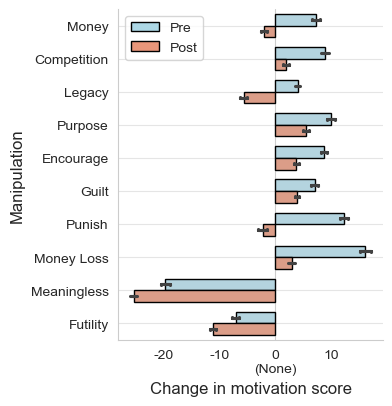

In [26]:
g = sns.catplot(data=plot_a_df[plot_a_df['manipulation'] != 'None'], 
                y='manipulation', x='value', hue='metric_name', kind='bar',
                hue_order=['Pre-self-report', 'Post-self-report'],
                order=[m for m in new_manip_order if m != 'None'],
                errorbar=('ci', 99), capsize=0.05, 
                width=0.7,
                height=4, aspect=1,
                palette=new_colors, alpha=1, 
                legend=False,
                edgecolor='black',
                )
ax = g.axes[0, 0]
xticks = ax.get_xticks()
xtick_labels = [f'{int(tick)}' if tick != 0 else '0\n(None)' for tick in xticks]
ax.set_xticklabels(xtick_labels)
ax.set_xlabel('Change in motivation score', fontsize=12)
ax.set_ylabel('Manipulation', fontsize=12)

ax.yaxis.grid(True, alpha=0.5)
for line in ax.get_xgridlines():
    if line.get_xdata()[0] != 0:
        line.set_visible(False)

# create custom legend
handles = [mpatches.Patch(facecolor=new_colors[metric], label=metric.split('-')[0], edgecolor='black') for metric in new_colors.keys()]
plt.legend(handles=handles, loc='upper left')
# save_plot('delta_motivation_reports_per_manipulation_plotA_all')
plt.show()

Plot B: manipulations, over all models, for overall performance, effort, and #tokens

In [27]:
cat_order = ["emotional-encourage", "competition", "money-loss", "demotivate-meaningless"]

# for appendix version, plot in two separated runs (each time different set)
# manip_wo_none = [m for m in manipulations if m != 'none']
# cat_order = manip_wo_none[:5]
# cat_order = manip_wo_none[5:]

manipulations_to_plot = cat_order + ['none']

plot_dfs = []
for model in models:
    if model == 'all':
        continue
    model = model_name_clean(model)
    df = pd.read_csv(f'tables/manipulation_analysis_results_{model}.csv')
       
    plot_df = df[df['metric_name'].isin(['Task Performance', 'Task Performance\n(Effort)', '#Tokens']) & 
                 df['category'].isin(manipulations_to_plot)
                ].copy()
    plot_df['model'] = model
    plot_dfs.append(plot_df)

plot_df_all = pd.concat(plot_dfs, ignore_index=True)

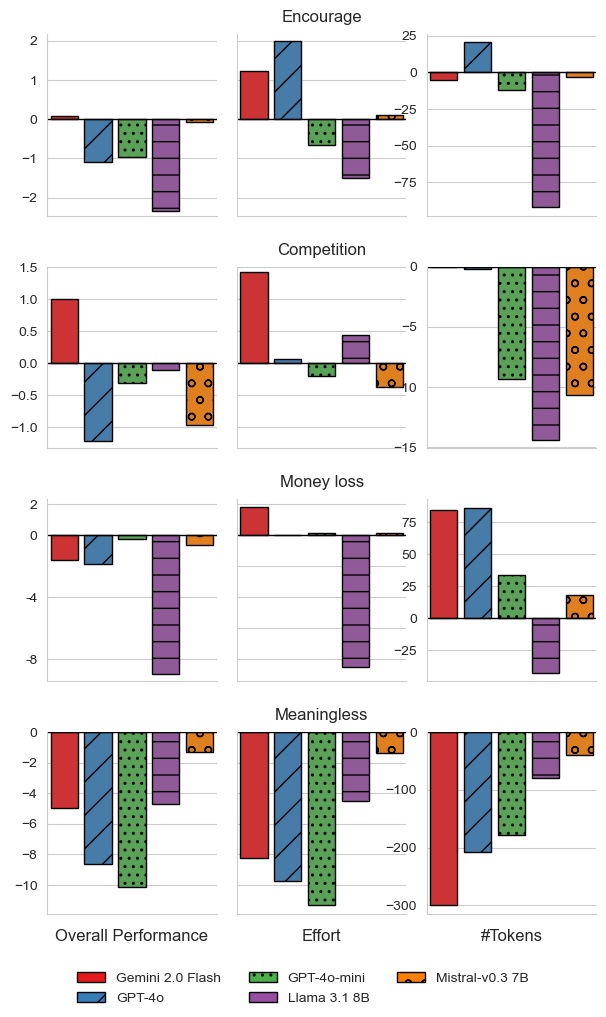

In [28]:
import seaborn as sns
df = plot_df_all.copy()
df.loc[df['metric_name'] != '#Tokens', "raw_score"] = df.loc[df['metric_name'] != '#Tokens', "raw_score"] * (100 / 7)

pretty = {
    "azure_gpt-4o": "GPT-4o",
    "azure_gpt-4o-mini": "GPT-4o-mini",
    "vertex_ai_gemini-2.0-flash": "Gemini 2.0 Flash",
    "ollama_chat_mistral_7b-instruct": "Mistral-v0.3 7B",
    "ollama_chat_llama3.1_8b-instruct-fp16": "Llama 3.1 8B",
}
hatches = {
    "GPT-4o": "/",
    "GPT-4o-mini": "..",
    "Gemini 2.0 Flash": "",
    "Mistral-v0.3 7B": "o",
    "Llama 3.1 8B": "-",
}
df["model_pretty"] = df["model"].map(pretty).fillna(df["model"])
model_order = [pretty.get(m, m) for m in df["model"].unique()]

# baseline "none" per (model, metric)
baseline = (df[df["category"] == "none"][["model", "metric_name", "raw_score"]].rename(columns={"raw_score": "raw_score_none"}))
# deltas vs none (per model, per metric)
plot_df = (df[df["category"] != "none"].merge(baseline, on=["model", "metric_name"], how="left"))
plot_df["delta_vs_none"] = plot_df["raw_score"] - plot_df["raw_score_none"]

plot_df = plot_df[plot_df["category"] != "none"]
plot_df['metric_name'] = plot_df['metric_name'].map({'Task Performance': 'Overall Performance',
                                                     'Task Performance\n(Effort)': 'Effort',
                                                     '#Tokens': '#Tokens'})
metric_order = ["Overall Performance", "Effort", "#Tokens"]

models_pretty_in_data = plot_df["model_pretty"].unique().tolist()
palette_list = sns.color_palette("Set1", n_colors=len(models_pretty_in_data))
palette = dict(zip(models_pretty_in_data, palette_list))

g = sns.catplot(
    data=plot_df,
    x="model_pretty",
    y="delta_vs_none",
    kind="bar",
    hue='model_pretty',
    row="category",
    col="metric_name",
    row_order=cat_order,
    col_order=metric_order,
    order=model_order,
    palette=palette,
    errorbar=None,
    edgecolor="black",
    height=2.5,
    aspect=0.8,
    sharey=False,
)

g.set_titles("")

# put metric_name in x-label (per column), category in y-label (per row)
for j, metric in enumerate(metric_order):
    for i in range(len(cat_order)):
        g.axes[i, j].set_xlabel(metric)

for i, cat in enumerate(cat_order):
    ax = g.axes[i, 1]
    # place text slightly above the row
    ax.annotate(
        mapping.get(cat, cat).capitalize(),
        xy=(0.5, 1.05),
        xycoords="axes fraction",
        ha="center",
        va="bottom",
        fontsize=12,
    )

for ax in g.axes.flatten():
    bars = ax.patches
    n_models = len(model_order)
    for i, bar in enumerate(bars):
        model = model_order[i % n_models]
        bar.set_hatch(hatches.get(model, ""))

for i, cat in enumerate(cat_order):
    for j in range(len(metric_order)):
        g.axes[i, j].set_ylabel(f"")

# Share y-limits within each row (but not across rows)
for i in range(len(cat_order)):
    row_axes = g.axes[i, :-1]
    ymin = min(ax.get_ylim()[0] for ax in row_axes)
    ymax = max(ax.get_ylim()[1] for ax in row_axes)
    for ax in row_axes:
        ax.set_ylim(ymin, ymax)
        
    # set y-tick labels only on left column
    g.axes[i, 1].set_yticklabels([])
    if cat_order[i] == 'money-loss':
        g.axes[i, 0].set_yticks([-8,-4,0,2])
        g.axes[i, 0].set_yticklabels([-8,-4,0,2])

for ax in g.axes.flatten():
    ax.axhline(0, color="black", linewidth=1)
    ax.set_xticklabels([])

g.fig.subplots_adjust(
    left=0.08, right=0.995,
    top=0.98, bottom=0.10,
    wspace=0.12, hspace=0.28
)

for ax in g.axes.flatten():
    ax.xaxis.label.set_size(12)

# add legend (custom) of models ("pretty" names)
handles = [
    mpatches.Patch(facecolor=palette[model], label=pretty.get(model, model),
                   edgecolor="black", hatch=hatches.get(model, ""))
    for model in model_order
]

# put legend above plot in one line
g.fig.legend(
    handles=handles,
    loc="lower center",
    ncol=3,
    frameon=False,
)

# save_plot('manipulation_effects_over_models_task_performance_and_effort_and_tokens2')
plt.show()